In [1]:
import numpy as np 
import pandas as pd 
import h5py
import os
import torch

import matplotlib.pyplot as plt 
import seaborn as sns
# plt.rcParams['font.family'] = 'Arial'

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import scSCC

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_name = 'QSTrachea'
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
with h5py.File("./XYData/" + 'QSTrachea' + '.h5', 'r') as f:
    X = np.array(f['X'])
    Y = np.array(f['Y']).reshape([
        -1,
    ])
    X = np.ceil(X).astype(np.float32)
    input_data = scSCC.normalizeData(X)
    input_data = input_data.X.astype(np.float32)

In [4]:
n_cluster = len(set(Y))

In [5]:
model = scSCC.scSCC(input_data,
                    n_cluster,
                    sample_name, device=device)
embeddings = model.train()

----- Traing phase -----


 75%|███████▌  | 150/200 [00:37<00:09,  5.24it/s]

epoch: 150


 75%|███████▌  | 150/200 [00:41<00:13,  3.65it/s]

Epoch 150: 
 	Loss: 5.384949326515198
	instanceLoss: 0
	stopARI: 1.0	 stopNMI: 1.0


In [6]:
res = scSCC.cluster_embedding(embeddings, n_cluster, real_label=Y, save_pred=True)
tsne_embed = TSNE(n_components=2).fit_transform(embeddings)
## pred labels are res['pred']
print(res['ari'], res['nmi']) 

0.9409 0.9046


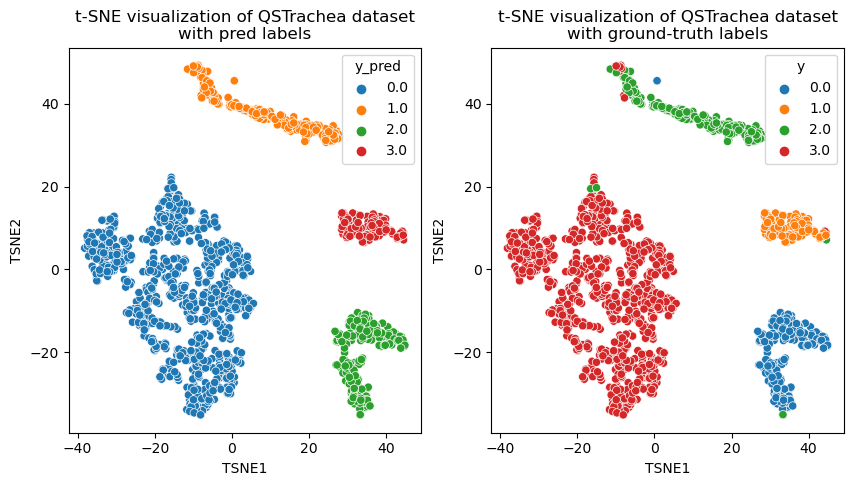

In [7]:
df = pd.DataFrame(np.concatenate([tsne_embed, np.vstack((Y, res['pred'])).T], axis=1), columns=["TSNE1", "TSNE2", 'y', 'y_pred'])
df['y'] = df['y'].astype('category')
df['y_pred'] = df['y_pred'].astype('category')

cols = ['y_pred', 'y']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(len(cols)):
    ax = axes[i]
    sns.scatterplot(df, x='TSNE1', y='TSNE2', hue=cols[i], ax=ax)
    title_name = 'pred' if cols[i] == 'y_pred' else 'ground-truth'
    ax.set_title('t-SNE visualization of %s dataset\nwith %s labels' % (sample_name, title_name))

# ##########   save figures ############### 
# save_pic_path = './figures'
# if not os.path.exists(save_pic_path):
#     os.makedirs(save_pic_path)
# plt.savefig(f"{save_pic_path}/{sample_name}_tSNE.png", dpi=300)